In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")


from experiments import Status


In [2]:
from collections import namedtuple

SMTCompResult = namedtuple("SMTCompResult", ["track", "benchmark_set", "benchmark", "solver", "status", "runtime"])

In [3]:
def parse_file(filepath):
    file = filepath.strip()
    parts = file.split("/")
    assert parts[-1][-5:] == ".smt2", f"{parts[-1]} does not end with .smt2!"
    return file, parts[0], parts[1]

def parse_outcome(outcome):
    outcome = outcome.strip().lower()
    if outcome == "sat":
        return Status.SAT
    if outcome == "unsat":
        return Status.UNSAT
    if "command exited" in outcome:
        return Status.ERROR
    if "command terminated" in outcome:
        return Status.ERROR
    if "parse error" in outcome:
        return Status.ERROR
    if "out of memory" in outcome:
        return Status.MEMORY_OUT
    if "error" in outcome:
        return Status.ERROR
    if "unknown" == outcome:
        return Status.ERROR
    if "starexec-unknown" == outcome:
        return Status.ERROR
    assert False, f"Unknown status: {outcome}"

def parse_log(logfile, solver):
    with open(logfile) as fp:
        while True:
            try:
                file, track, benchmark_set = parse_file(next(fp))
                outcome = parse_outcome(next(fp))
                runtime = float(next(fp))
                runtime = runtime if outcome in [Status.SAT, Status.UNSAT, Status.TIMEOUT] else float("inf")
                yield SMTCompResult(track, benchmark_set, file, solver, outcome, runtime)
            except StopIteration:
                break
    
ostrich_catra = pd.DataFrame(parse_log("/Users/amanda/Downloads/smt-comp-nowarn-nohash", "ostrich-catra"))
ostrich_catra

,track,benchmark_set,benchmark,solver,status,runtime
0,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_4646_sink.smt2,ostrich-catra,Status.SAT,7.50
1,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_1641_sink.smt2,ostrich-catra,Status.SAT,6.95
2,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_2526_sink.smt2,ostrich-catra,Status.UNSAT,4.93
3,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_5103_sink.smt2,ostrich-catra,Status.ERROR,inf
4,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_757_sink.smt2,ostrich-catra,Status.UNSAT,6.74
...,...,...,...,...,...,...
30850,QF_SNIA,20180523-Reynolds,QF_SNIA/20180523-Reynolds/kaluza/sat/big/809.c...,ostrich-catra,Status.SAT,5.43
30851,QF_SNIA,20180523-Reynolds,QF_SNIA/20180523-Reynolds/kaluza/sat/small/159...,ostrich-catra,Status.SAT,5.69
30852,QF_SNIA,20180523-Reynolds,QF_SNIA/20180523-Reynolds/kaluza/sat/small/200...,ostrich-catra,Status.SAT,6.12
30853,QF_SNIA,20180523-Reynolds,QF_SNIA/20180523-Reynolds/kaluza/sat/small/155...,ostrich-catra,Status.SAT,6.33


In [4]:
used_benchmarks = [line.strip() for line in open("/Users/amanda/Downloads/smt-comp2023")]
smt_comp = pd.read_csv("/Users/amanda/Downloads/Job59410_info.zip")
smt_comp_fixed = pd.read_csv("/Users/amanda/Downloads/Job59668_info.zip")
ostrich_fixed = smt_comp_fixed[smt_comp_fixed["solver"] == "OSTRICH 1.3 SMT-COMP fixed"]
smt_comp = smt_comp[smt_comp.solver != "OSTRICH 1.3 SMT-COMP"]
smt_comp = pd.concat([smt_comp, ostrich_fixed])
smt_comp['benchmark'] = smt_comp['benchmark'].str.replace("track_single_query/", "")
smt_comp = smt_comp[smt_comp['benchmark'].isin(used_benchmarks)]
smt_comp = smt_comp.rename(columns={"wallclock time": "runtime"})
smt_comp['track'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[1])
smt_comp['benchmark_set'] = smt_comp.benchmark.apply(lambda x: parse_file(x)[2])
smt_comp['status'] = smt_comp["result"].apply(parse_outcome)
smt_comp = smt_comp.drop(columns=["result"])
df = pd.concat([ostrich_catra, smt_comp])
df['solver'] = df['solver'].astype("category")
df['status'] = df['status'].astype("category")
df['track'] = df['track'].astype("category")
df['benchmark'] = df['benchmark'].astype("category")
df['benchmark_set'] = df['benchmark_set'].astype("category")
df['status'] = df['status'].cat.set_categories([Status.SAT, Status.UNSAT, Status.TIMEOUT, Status.MEMORY_OUT, Status.ERROR], ordered=True)
df = df.drop(["solver id", "benchmark id", "configuration id", "cpu time", "memory usage", "pair id"], axis=1)
# This fills NaN columns using the first non-NaN value in the group, essentially populating expected outcomes etc.
df.update(df.groupby(['benchmark'])[['expected', 'configuration']].bfill())
df.update(df.groupby(['benchmark'])[['expected', 'configuration']].ffill())

In [5]:
df.groupby('solver').size()

solver
OSTRICH 1.3 SMT-COMP fixed           30855
Z3-Noodler                           30785
cvc5-default-2023-05-16-ea045f305    30855
ostrich-catra                        30855
z3alpha                              30855
dtype: int64

In [6]:
# Create a new solver which is the best output of ostrich and ostrich-catra:
portfolio_results = df[df.solver.isin(["ostrich-catra", "OSTRICH 1.3 SMT-COMP fixed"])]\
    .sort_values(['status', 'runtime'])\
    .groupby("benchmark")\
    .first()\
    .reset_index()\
    .assign(solver="both OSTRICHes")

In [7]:
df = pd.concat([df, portfolio_results])

In [8]:
df.groupby('solver').size()

solver
OSTRICH 1.3 SMT-COMP fixed           30855
Z3-Noodler                           30785
both OSTRICHes                       30855
cvc5-default-2023-05-16-ea045f305    30855
ostrich-catra                        30855
z3alpha                              30855
dtype: int64

In [9]:
df.benchmark.unique().size

30855

## Soundness check

In [10]:
success_runs = df[df['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['benchmark'])

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
contested = nr_statuses[nr_statuses['status'] > 1]
contested

,benchmark,status
4823,QF_S/20230329-automatark-lu/instance08425.smt2,2
15695,QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc...,2
16558,QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc...,2
16559,QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc...,2
19588,QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc...,2
19887,QF_SLIA/2019-Jiang/slent/slent_stranger_str_re...,2


In [11]:
df[(df.benchmark.isin(contested.benchmark)) & (df.status < Status.TIMEOUT)]\
    .set_index(["benchmark", "solver"])\
    .drop(["track", "runtime", "configuration", "benchmark_set"], axis=1) \
    .sort_values("benchmark")

status  \
benchmark                                          solver                                            
QF_S/20230329-automatark-lu/instance08425.smt2     ostrich-catra                      Status.UNSAT   
                                                   Z3-Noodler                           Status.SAT   
                                                   cvc5-default-2023-05-16-ea045f305    Status.SAT   
                                                   z3alpha                              Status.SAT   
                                                   both OSTRICHes                       Status.SAT   
                                                   OSTRICH 1.3 SMT-COMP fixed           Status.SAT   
QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc-... ostrich-catra                      Status.UNSAT   
                                                   Z3-Noodler                           Status.SAT   
                                                   cvc5-default-2023-05-16-ea045f305  Status.UNSAT   
                                                   z3alpha                            Status.UNSAT   
                                                   OSTRICH 1.3 SMT-COMP fixed         Status.UNSAT   
                                                   both OSTRICHes                     Status.UNSAT   
QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc-... cvc5-default-2023-05-16-ea045f305  Status.UNSAT   
                                                   Z3-Noodler                           Status.SAT   
QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc-... cvc5-default-2023-05-16-ea045f305  Status.UNSAT   
                                                   Z3-Noodler                           Status.SAT   
QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc-... cvc5-default-2023-05-16-ea045f305  Status.UNSAT   
                                                   z3alpha                            Status.UNSAT   
                                                   OSTRICH 1.3 SMT-COMP fixed         Status.UNSAT   
                                                   Z3-Noodler                           Status.SAT   
                                                   both OSTRICHes                     Status.UNSAT   
QF_SLIA/2019-Jiang/slent/slent_stranger_str_rep... Z3-Noodler                         Status.UNSAT   
                                                   cvc5-default-2023-05-16-ea045f305    Status.SAT   
                                                   z3alpha                              Status.SAT   

                                                                                              expected  
benchmark                                          solver                                               
QF_S/20230329-automatark-lu/instance08425.smt2     ostrich-catra                                   sat  
                                                   Z3-Noodler                                      sat  
                                                   cvc5-default-2023-05-16-ea045f305               sat  
                                                   z3alpha                                         sat  
                                                   both OSTRICHes                                  sat  
                                                   OSTRICH 1.3 SMT-COMP fixed                      sat  
QF_SLIA/20180523-Reynolds/pyex/peterc-pyex-doc-... ostrich-catra                      starexec-unknown  
                                                   Z3-Noodler                         starexec-unknown  
                                                   cvc5-default-2023-05-16-ea045f305  starexec-unknown  
                                                   z3alpha                            starexec-unknown  
                                                   OSTRICH 1.3 SMT-COMP fixed         starexec-unknown  
                                                   both OSTRICHes         

In [12]:
df[df['status'] > Status.TIMEOUT]

,track,benchmark_set,benchmark,solver,status,runtime,configuration,expected
3,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_5103_sink.smt2,ostrich-catra,Status.ERROR,inf,default,starexec-unknown
16,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_4192_sink.smt2,ostrich-catra,Status.ERROR,inf,default,starexec-unknown
17,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_4638_sink.smt2,ostrich-catra,Status.ERROR,inf,default,starexec-unknown
18,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_5231_sink.smt2,ostrich-catra,Status.ERROR,inf,default,starexec-unknown
23,QF_S,2019-Jiang,QF_S/2019-Jiang/slog/slog_stranger_5230_sink.smt2,ostrich-catra,Status.ERROR,inf,default,starexec-unknown
...,...,...,...,...,...,...,...,...
30751,QF_SLIA,20230403-webapp,QF_SLIA/20230403-webapp/str-rep/str_replace49....,both OSTRICHes,Status.ERROR,1200.12,def,starexec-unknown
30758,QF_SLIA,20230403-webapp,QF_SLIA/20230403-webapp/str-rep/str_replace66....,both OSTRICHes,Status.ERROR,1200.11,def,starexec-unknown
30776,QF_SLIA,20230403-webapp,QF_SLIA/20230403-webapp/str-rep/str_replace88....,both OSTRICHes,Status.ERROR,1200.03,def,starexec-unknown
30778,QF_SLIA,20230403-webapp,QF_SLIA/20230403-webapp/str-rep/str_replace90....,both OSTRICHes,Status.ERROR,1200.04,def,starexec-unknown


In [13]:
def plot_results(df, title="Outcome by solver"):
    fig, ax = plt.subplots()
    runtime_by_status = df.groupby(['solver', 'status']).size().reset_index()
    runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
    runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
    runtime_by_status = runtime_by_status.set_index(['solver', 'status'])
    plot = runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title=title, 
                                     ax=ax)


    nr_solvers = df.solver.nunique()
    bars = plot.patches
    hatches = [ *(["*"] * nr_solvers), *(["."] * nr_solvers), *(["/"] * nr_solvers), *(["x"] * nr_solvers)]


    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])


#plt.tight_layout()
#plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

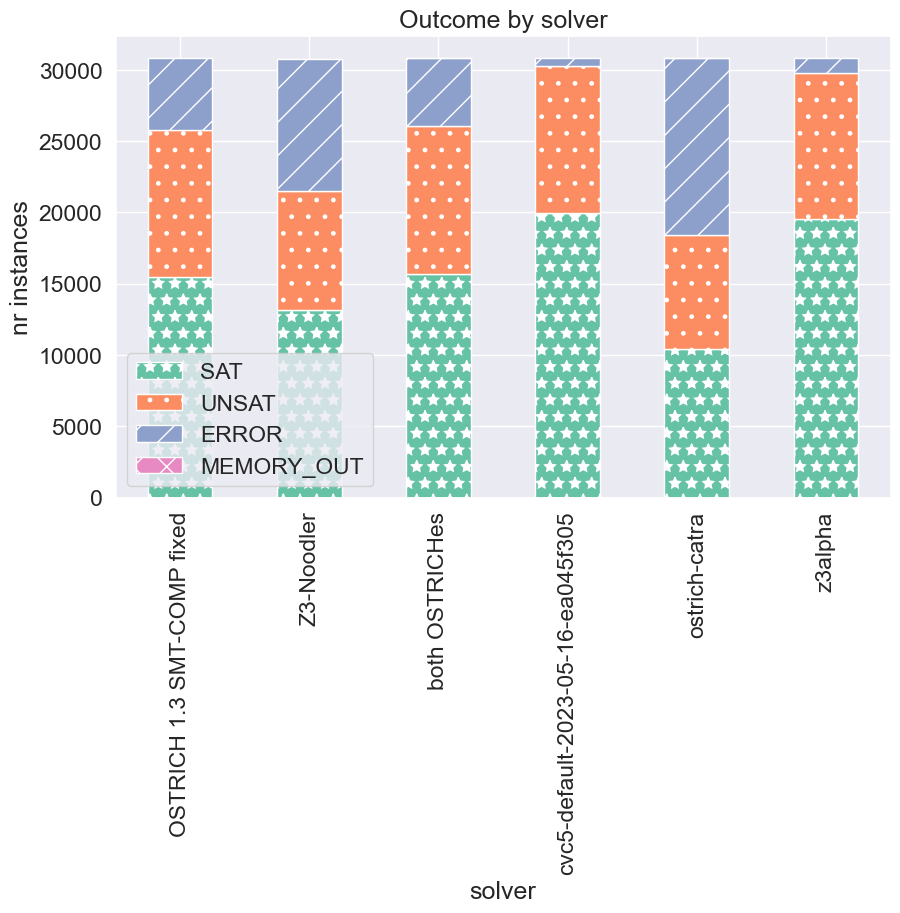

In [14]:
plot_results(df)

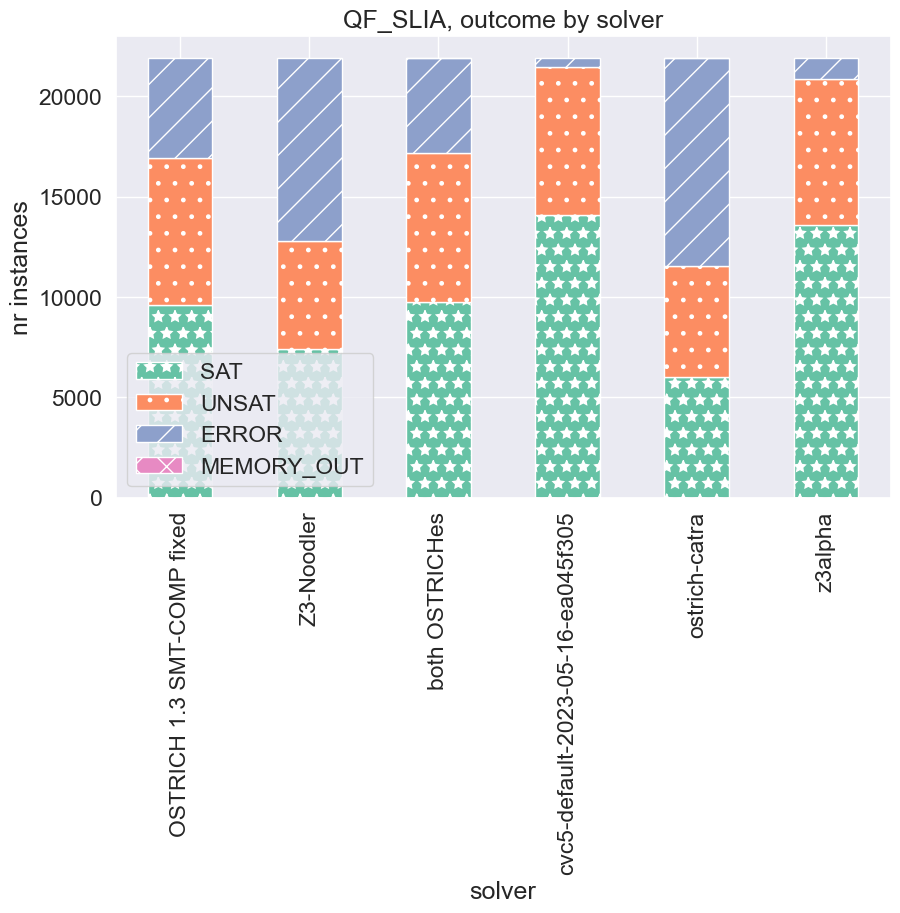

In [15]:
plot_results(df[(df.track == "QF_SLIA")], "QF_SLIA, outcome by solver")

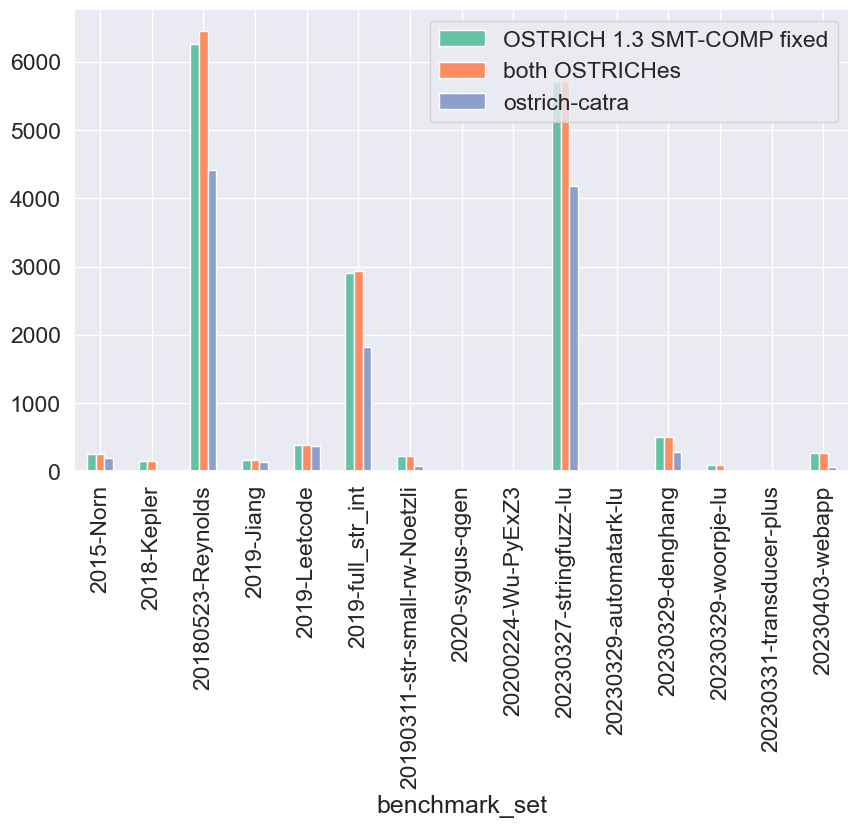

In [41]:
fig, ax = plt.subplots()


df[(df.track == 'QF_SLIA') & (df.solver.isin(["OSTRICH 1.3 SMT-COMP fixed", "ostrich-catra", "both OSTRICHes"])) & (df.status < Status.TIMEOUT)]\
    .groupby(["benchmark_set", "solver"])\
    .size()\
    .reset_index()\
    .rename(columns = {0: 'solved'})\
    .set_index(["benchmark_set", "solver"])\
    .unstack()\
    .plot\
    .bar(ax=ax, figsize=(10,6))

_, labels = ax.get_legend_handles_labels()

ax.legend(list(map(lambda x: x.replace("solved, ", "").replace("(", "").replace(")", ""), labels)))

In [47]:
by_sat_status = pd.DataFrame(df.groupby('benchmark').status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = df[df['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='benchmark')

tbl = pd.pivot_table(known_solved_with_kind[known_solved_with_kind.track == "QF_SLIA"], values=['runtime'], 
               index=['kind'], columns=['solver'],
               aggfunc='count')['runtime']
tbl.index = tbl.index.to_series().map(lambda x: str(x).replace("Status.", ""))
tbl.index.rename({"cvc5-default-2023-05-16-ea045f305":"cvc5"})
tbl
#tbl.style.to_latex("solved_pivot_table.tex", hrules=True)
#tbl

TypeError: CategoricalIndex.name must be a hashable type

In [ ]:
tbl.columns